# Deep convolution


On va découvrir les réseaux de neurone convolutionnels qui sont très fort pour analyser des signaux (images, sons, vidéos).

Même des images mal dessinées: testez [quick draw](https://quickdraw.withgoogle.com/)



In [ ]:
%reset -f

In [ ]:
import numpy as np
import os
import torch

import matplotlib.pyplot as plt
np.set_printoptions(linewidth=500,precision=2,suppress=True)


## Les shapes des images et des kernels

### Torch

En `pytorch`  les images sont stockées dans des tenseurs `X` de dimension 4:

     X.shape=(batch_size, img_n_channel, img_height, img_width)


* `batch_size`: le nombre d'images que l'on traites en même temps
* `img_n_channel`: chaque channel correspond à une "caractérisitique" des pixels. Les images noir et blanc on 1 channel, les images couleurs en ont 3 ou 4 (avec la transparence). Mais les réseaux de neurones convolutif (qu'on va découvrir) créent des images dans leur couche cachées qui peuvent avoir des centaines de channels!  
* `img_height, img_width`: les dimensions des images




Les noyaux de convolutions sont aussi placés dans un tenseur `W` de dimension 4,  mais ces 4 dimension ont une signification différent:

    W.shape=(n_channel_out, n_channel_in, img_height, img_width)




Pour que la convolution entre `X` et `W` fonctionne, il faut simplement que le nombre de channel `img_n_chanel`=`n_channel_in`. Le résultat `Y=conv(X,W)` (avec l'option `padding=same`) sera un tenseur-image  de shape:

      Y.shape=(batch_size, n_channel_out, img_height, img_width)



La formule de convolutions est donnée par:

       Y = conv(X,W) [b, c , i, j]     =    sum_{di, dj, q}  X[b, q,  i + di ,  j + dj] *  W[c, q, di, dj]
      
      
Observons cette formule:

* l'indice  `b` reste inchangé entre l'entrée X et la sortie Y. Ainsi les images au sein d'un batch sont traitées individuellements.
* l'indice `c` n'est pas sommé. Ainsi si `W` à 10 `channels_out`, on effectue simplement 10 convolutions différentes.
* la concolution est faites avec les indices `i,j,di,dj`.
* Observons `q`: La convolution est effectuée en parallèle entre tous les channels de l'image et tous les channel_in du kernel.  Tous les résultats de ces convolutions sont ensuite sommés. Cela crée un beau mélange.




Remarquons que lorsque `kernel_height=kernel_width=1`  on effectue simplement une multiplication matricielle.


In [ ]:
batch_size=1
img_n_channel=3
img_height,img_width=30,30
X=torch.rand(batch_size,img_n_channel,img_height,img_width)


n_channel_in=3
assert n_channel_in==img_n_channel
n_channel_out=5

kernel_height,kernel_width = 7,5


layer=torch.nn.Conv2d(n_channel_in,n_channel_out,(kernel_height,kernel_width),padding="same")

Y=layer(X)
assert Y.shape== (batch_size,n_channel_out,img_height,img_width)
Y.shape

Observons l'intérieur du layer

In [ ]:
params= list(layer.parameters())
kernel=params[0]
bias=params[1]
print(kernel.shape)
print(bias.shape)

In [ ]:
assert kernel.shape==(n_channel_out,n_channel_in,kernel_height,kernel_width)

### Un petit tours par tensorflow

On travaille avec la convention 'channel_last', donc les images sont rangées dans des tenseurs.

     X.shape=(batch_size, img_height, img_width, img_n_channel)




Et de plus la multiplication matricielle se fait dans l'autre sens. Donc les kernels sont de shape


    W.shape=(kernel_height, kernel_width, n_channel_in, n_channel_out)


Et la convolution correspond donc à:

    Y = conv(X,W) [b, i, j, c]     =    sum_{di, dj, q}  X[b,   i + di ,  j + dj, q] *  W[di, dj, q, c]
      


Personnellement je trouve la convention channel-last plus pratique et plus répandues:

* Le format classique des images (jpeg, png) est channel-last.

* on est souvent amener à appliquer des layer dense sur les channels. Or les layer denses, dans toutes les librairies, s'appliquent toujours sur le dernier indice. * En torch il faut donc transposer
* ou bien: utiliser une convolution avec `kernel_height,kernel_width=1,1` à la place des layer dense.




## Observons sur des images

In [ ]:

"fonctions utilitaires"
def plot_images(images):

    batch_size,n_channel,_,_=images.shape


    fig,axs=plt.subplots(batch_size,n_channel,figsize=(2*n_channel,2*batch_size))
    axs=axs.reshape([batch_size,n_channel])#au cas une des quantité vaut 1

    for i in range(batch_size):
        for j in range(n_channel):
            axs[i,j].imshow(images[i,j,:,:], interpolation="nearest")
            if j==0:
                axs[i,j].set_ylabel(f"{i}-ième image")
            if i==0:
                axs[i,j].set_title(f"{j}-ième channel")
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    fig.tight_layout()

### Plusieurs convolutions sur plusieurs images

In [ ]:
"on importe deux images depuis sklearn: une pagote et une fleur"
from sklearn.datasets import load_sample_image
height, width=220,250
image0 = load_sample_image("china.jpg")[100:100+height, 100:100+width]
image1 = load_sample_image("flower.jpg")[100:100+height, 100:100+width]
print(np.min(image0),np.max(image0))

In [ ]:
"on les stack dans un tenseur"
images=np.stack([image0,image1]).astype(np.float32)/255
images.shape

In [ ]:
images=torch.permute(torch.tensor(images),[0,3,1,2])
images.shape

In [ ]:
plot_images(images)

In [ ]:
"on crée une version en niveaux de gris"
images_gray = images.mean(axis=1)
images_gray=images_gray[:,None,:,:]
images_gray.shape

In [ ]:
plot_images(images_gray)

### Manipulons les images en niveau de gris

In [ ]:
kernel_manual = torch.zeros([2,1,11, 11])
kernel_manual[0,0,:, 5] = 1
kernel_manual[1,0,5, :] = 1

In [ ]:
fig,(ax0,ax1)=plt.subplots(1,2)
ax0.imshow(kernel_manual[0,0,:,:])
ax1.imshow(kernel_manual[1,0,:,:]);

In [ ]:
layer=torch.nn.Conv2d(1,2,(11,11))
kernel,bias=tuple(layer.parameters())
kernel.shape,bias.shape

In [ ]:
kernel.data=kernel_manual
bias.data=torch.zeros(bias.shape)

In [ ]:
Y=layer(images_gray).detach()
Y.shape

In [ ]:
plot_images(Y)

### Manipulons les images couleurs

In [ ]:
kernel_manual = torch.zeros([3,3,1, 1])
kernel_manual[:,:,0,0] = -torch.eye(3)

In [ ]:
layer=torch.nn.Conv2d(3,3,(1,1))
kernel,bias=tuple(layer.parameters())
kernel.shape,bias.shape

In [1]:
kernel.data=kernel_manual
bias.data=torch.zeros_like(bias.data)

In [ ]:
Y=layer(images).detach()
Y.shape

In [ ]:
plot_images(Y)

### Manipulons les images couleurs 2

In [ ]:
kernel_manual = torch.zeros([3,3,51,51])
kernel_manual[:,:,-1,-1] = 1

In [ ]:
kernel_manual.shape

In [ ]:
layer=torch.nn.Conv2d(3,3,(1,1))
kernel,bias=tuple(layer.parameters())
kernel.shape,bias.shape

In [ ]:
kernel.data=kernel_manual
bias.data=torch.zeros_like(bias)

In [ ]:
Y=layer(images).detach()
Y.shape

In [ ]:
plot_images(Y)

## Padding, stride, initialisation

###  padding





Le padding c'est le fait de rajouter des zéros autour de l'image.
* Si on ajoute verticallement `padding_height` pixel
* Si on ajoute horizontallement `padding_width` pixel

La taille de l'image après convolution est:

                    img_out_height =  img_in_height + padding_height - kernel_height  + 1
                    img_out_width  =  img_in_width  + padding_width  - kernel_width   + 1


***A vous:***  Dessinez  sur un papier un cadrillage 10 $\times$ 10 représentant une image. Effectuez la convolution avec un noyau 3$\times$3 en prenant un padding de 0 (`padding=="VALID"`). Vérifiez la *formule générale* (notamment pour comprendre notamment le +1 de la fin).


L'argument padding de `torch.nn.Conv2d` peut prendre 3 types d'arguments:
* Une paire d'entier indiquant `padding_height,padding_width`
* Un unique entier `padding` qui sera transformé utilisé à la fois pour `padding_height` et  `padding_width`
* Une string qui peut être `"same"` ou `"valid"`, cette dernière option étant la valeur par défaut.







#### →♡

Le mode `valide` correspond simplement à `padding=0`. Le mode `same` s'arrange pour que l'image de sortie ai la même dimension que l'image d'entrée. Ains:

padding_heigh=...

kernel_width=...


Pour être précis, les zéro du padding sont répartis tout autour de l'image. En général on prend des taille de padding impair. Par exemple si `padding_width`=5, on ajoute alors 2 colonnes de zéros à droite de l'image et deux colonnes de zéros à gauche.




In [ ]:
kernel_height,kernel_width=15,23
for padding in ["same","valid"]:
    layer=torch.nn.Conv2d(3,1,(kernel_height,kernel_width),padding=padding)
    Y=layer(images)
    print(Y.shape)

#### →♡♡♡

Comprenez le warning ci-dessous, et essayer de le faire apparaitre. Attention, il n'apparait qu'une seule fois par cession.

     UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
    return F.conv2d(input, weight, bias, self.stride,

#### → ♡♡

Ajoutez la légende aux animations ci-dessous. Vous avez le choix entre `same`, `valid`, `full`. Ce dernier met le padding 'maximal' pour le la convolution soit intéressante. Mais il n'est pas implémenté en torch (mais en numpy/scipy, oui).

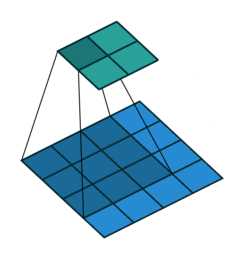

 Ajoutez une légende ...


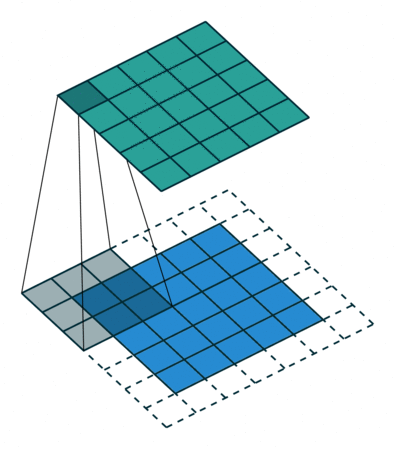

 Ajoutez une légende ...


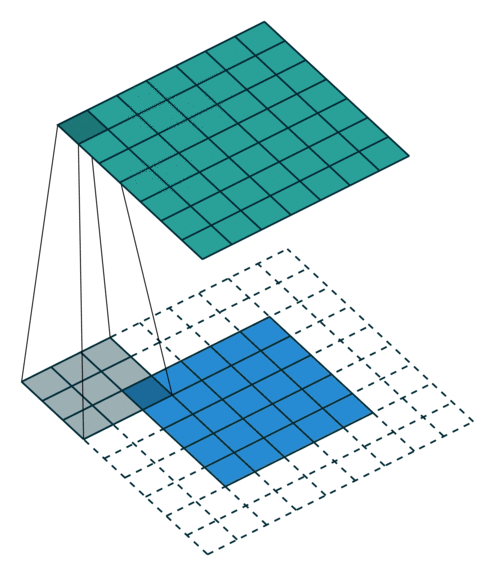

 Ajoutez une légende ...


### Ne pas remplir qu'avec des zéros

L'argument `padding_mode` permet de remplir les pixels de padding avec autre chose que des zéros.



In [ ]:
for padding_mode in ['zeros', 'reflect', 'replicate', 'circular']:
    layer=torch.nn.Conv2d(3,3,(1,1),padding=(21,21),padding_mode=padding_mode)
    kernel,bias=tuple(layer.parameters())
    kernel.data=torch.ones(kernel.shape)
    bias.data=torch.zeros(bias.shape)
    Y=layer(images).detach()
    plot_images(Y)
    plt.show()

Les options `reflect` et `replicate` l'intérêt de prolonger par 'continuité' l'image. La convolution qui vient par dessus est donc plus naturelle.

L'option `circular` est intéressante quand on travaille avec des images périodiques.


### Stride

Le stride c'est le pas de déplacement du noyau de convolution.
Ainsi avec stride=2, le noyau saute un pixel sur deux. L'image résultante de la convolution est, grosso mode, deux fois plus petite.



Cela peut remplacer le max-pooling (cf plus loin). Certains dise que c'est mieux, d'autre non.



In [ ]:
kernel_height,kernel_width=15,23
for stride in [2,3,4]:
    layer=torch.nn.Conv2d(3,1,(kernel_height,kernel_width),stride=stride)
    Y=layer(images)
    print(Y.shape)

On peut combiner le stridde et le padding. Ci-dessous des animations avec `stridde=2`.

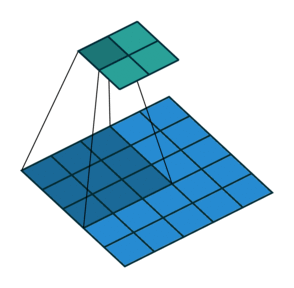

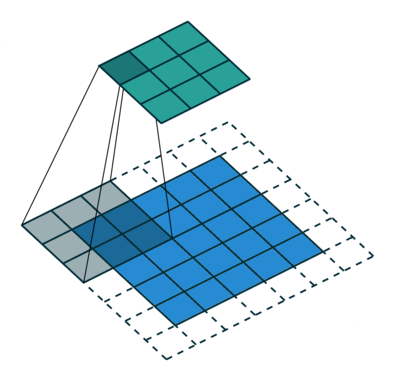

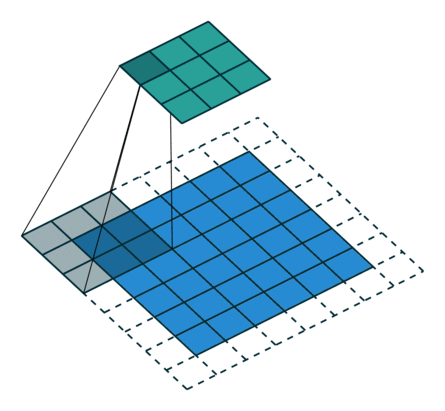

In [ ]:
try:
    torch.nn.Conv2d(3,1,(3,3),stride=2,padding="same")
except Exception as e:
    print(e)

### Dilatation

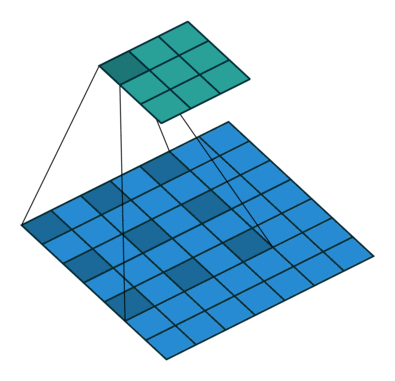

Quand on mélange tous les paramètres, la taille finale se calcul par la formule (tirée de l'aide de torch):

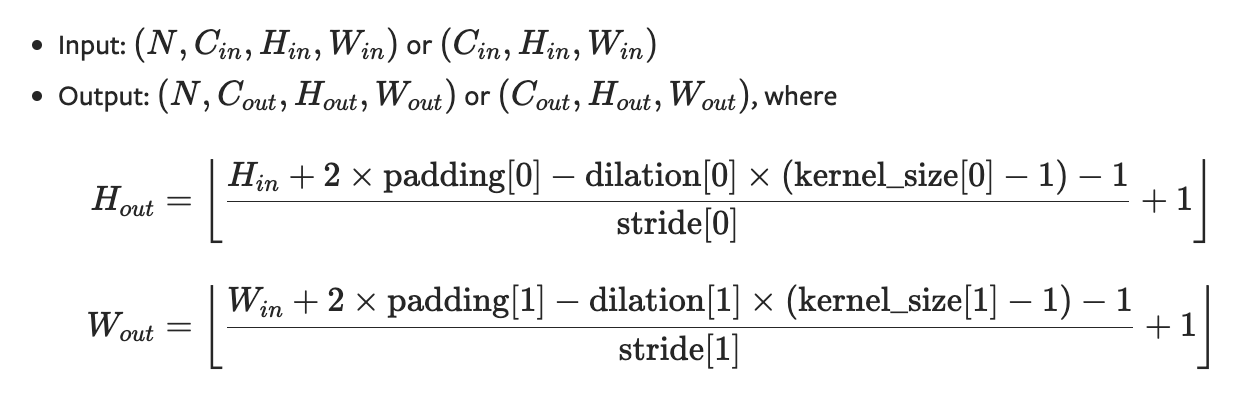

$\lfloor a \rfloor$ représente la partie entière inférieure.

### Initialisation du kernel et du biais

Chaque élément du kernel et du biais est tiré celon une loi uniforme sur $[-\sqrt{a},\sqrt{a}]$ avec
$$
a={1\over \mathtt{n\_channel\_in}\times \mathtt{kernel\_height} \times \mathtt{kernel\_width}}
$$
Cela permet de garder la variance du signal constante (tout comme dans les layer `Linear`).

## Max Pooling


### Principe


Quand on fait:

    layer=torch.nn.MaxPool2d(kernel_size=kernel_size,stride=stride)
    Y=layer(images)

on prend une fenêtre de taille `kernel_size,kernel_size`. On la fait glisser sur l'image exactement comme une convolution, avec un pas égal à `stride` en gardant pour chaque position le maximum de la fenêtre.

Mais attention, dans ce layer, quand on ne précise pas `stride`, par défault il est pris égal à `kernel_size`.


On peut aussi donner un couples `kernel_size=(kernel_heigt,kernel_with)` si on veut une fenêtre rectangulaire. Et on peut aussi mettre un couple pour l'argument `stride` pour glisser différemment verticalement et horizontalement.


In [ ]:
for kernel_size in [2,3,4,5]:
    layer=torch.nn.MaxPool2d(kernel_size)
    Y=layer(images)
    print(Y.shape)
    plot_images(Y)
    plt.show()

## Exo: Un filtre de Sobel


In [ ]:
#construisons une petite image pour tester
x = torch.zeros([28, 28])
x[5:10, 10:20] = 1
plt.imshow(x);

In [ ]:
#on rend l'image de dimension 4
x = x[None,None,:,:]
x.shape

construisons un noyau qui calcule une dérivée directionnelle horizontale

In [ ]:
W=torch.tensor(


    tensor([[-1.,  0.,  1.],
            [-2.,  0.,  2.],
            [-1.,  0.,  1.]])

construisons un noyau qui calcule une dérivée directionnelle verticale

In [ ]:
WT=torch.transpose()
WT

    tensor([[-1., -2., -1.],
            [ 0.,  0.,  0.],
            [ 1.,  2.,  1.]])

Créons le layer de convolution:

In [ ]:
layer=torch.nn.Conv2d(1,2,3)
kernel,bias=tuple(layer.parameters())
kernel.shape,bias.shape

Modifions les poids:

In [ ]:
bias.data=torch.zeros(bias.shape)

#### →♡♡

In [ ]:
#maintenant modifions kernel.data


In [ ]:
Y=layer(x).detach()
Y.shape

    torch.Size([1, 2, 26, 26])

In [ ]:
plot_images(Y)

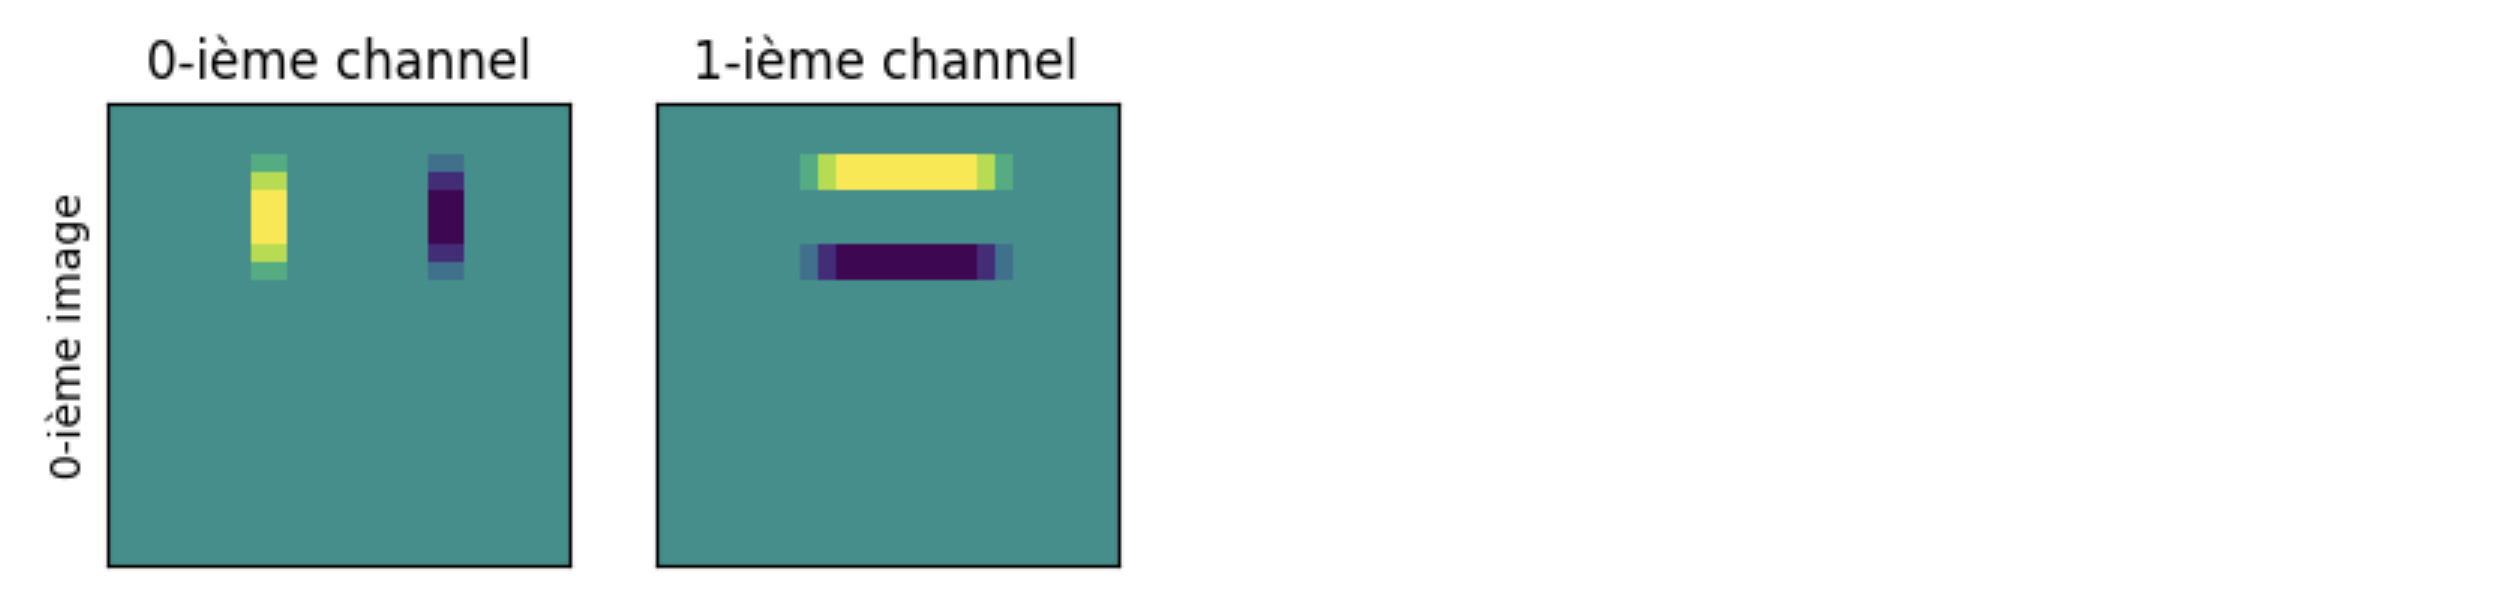

In [ ]:
border=torch.sum(Y**2,dim=1)[0,:,:]
plt.imshow(border);

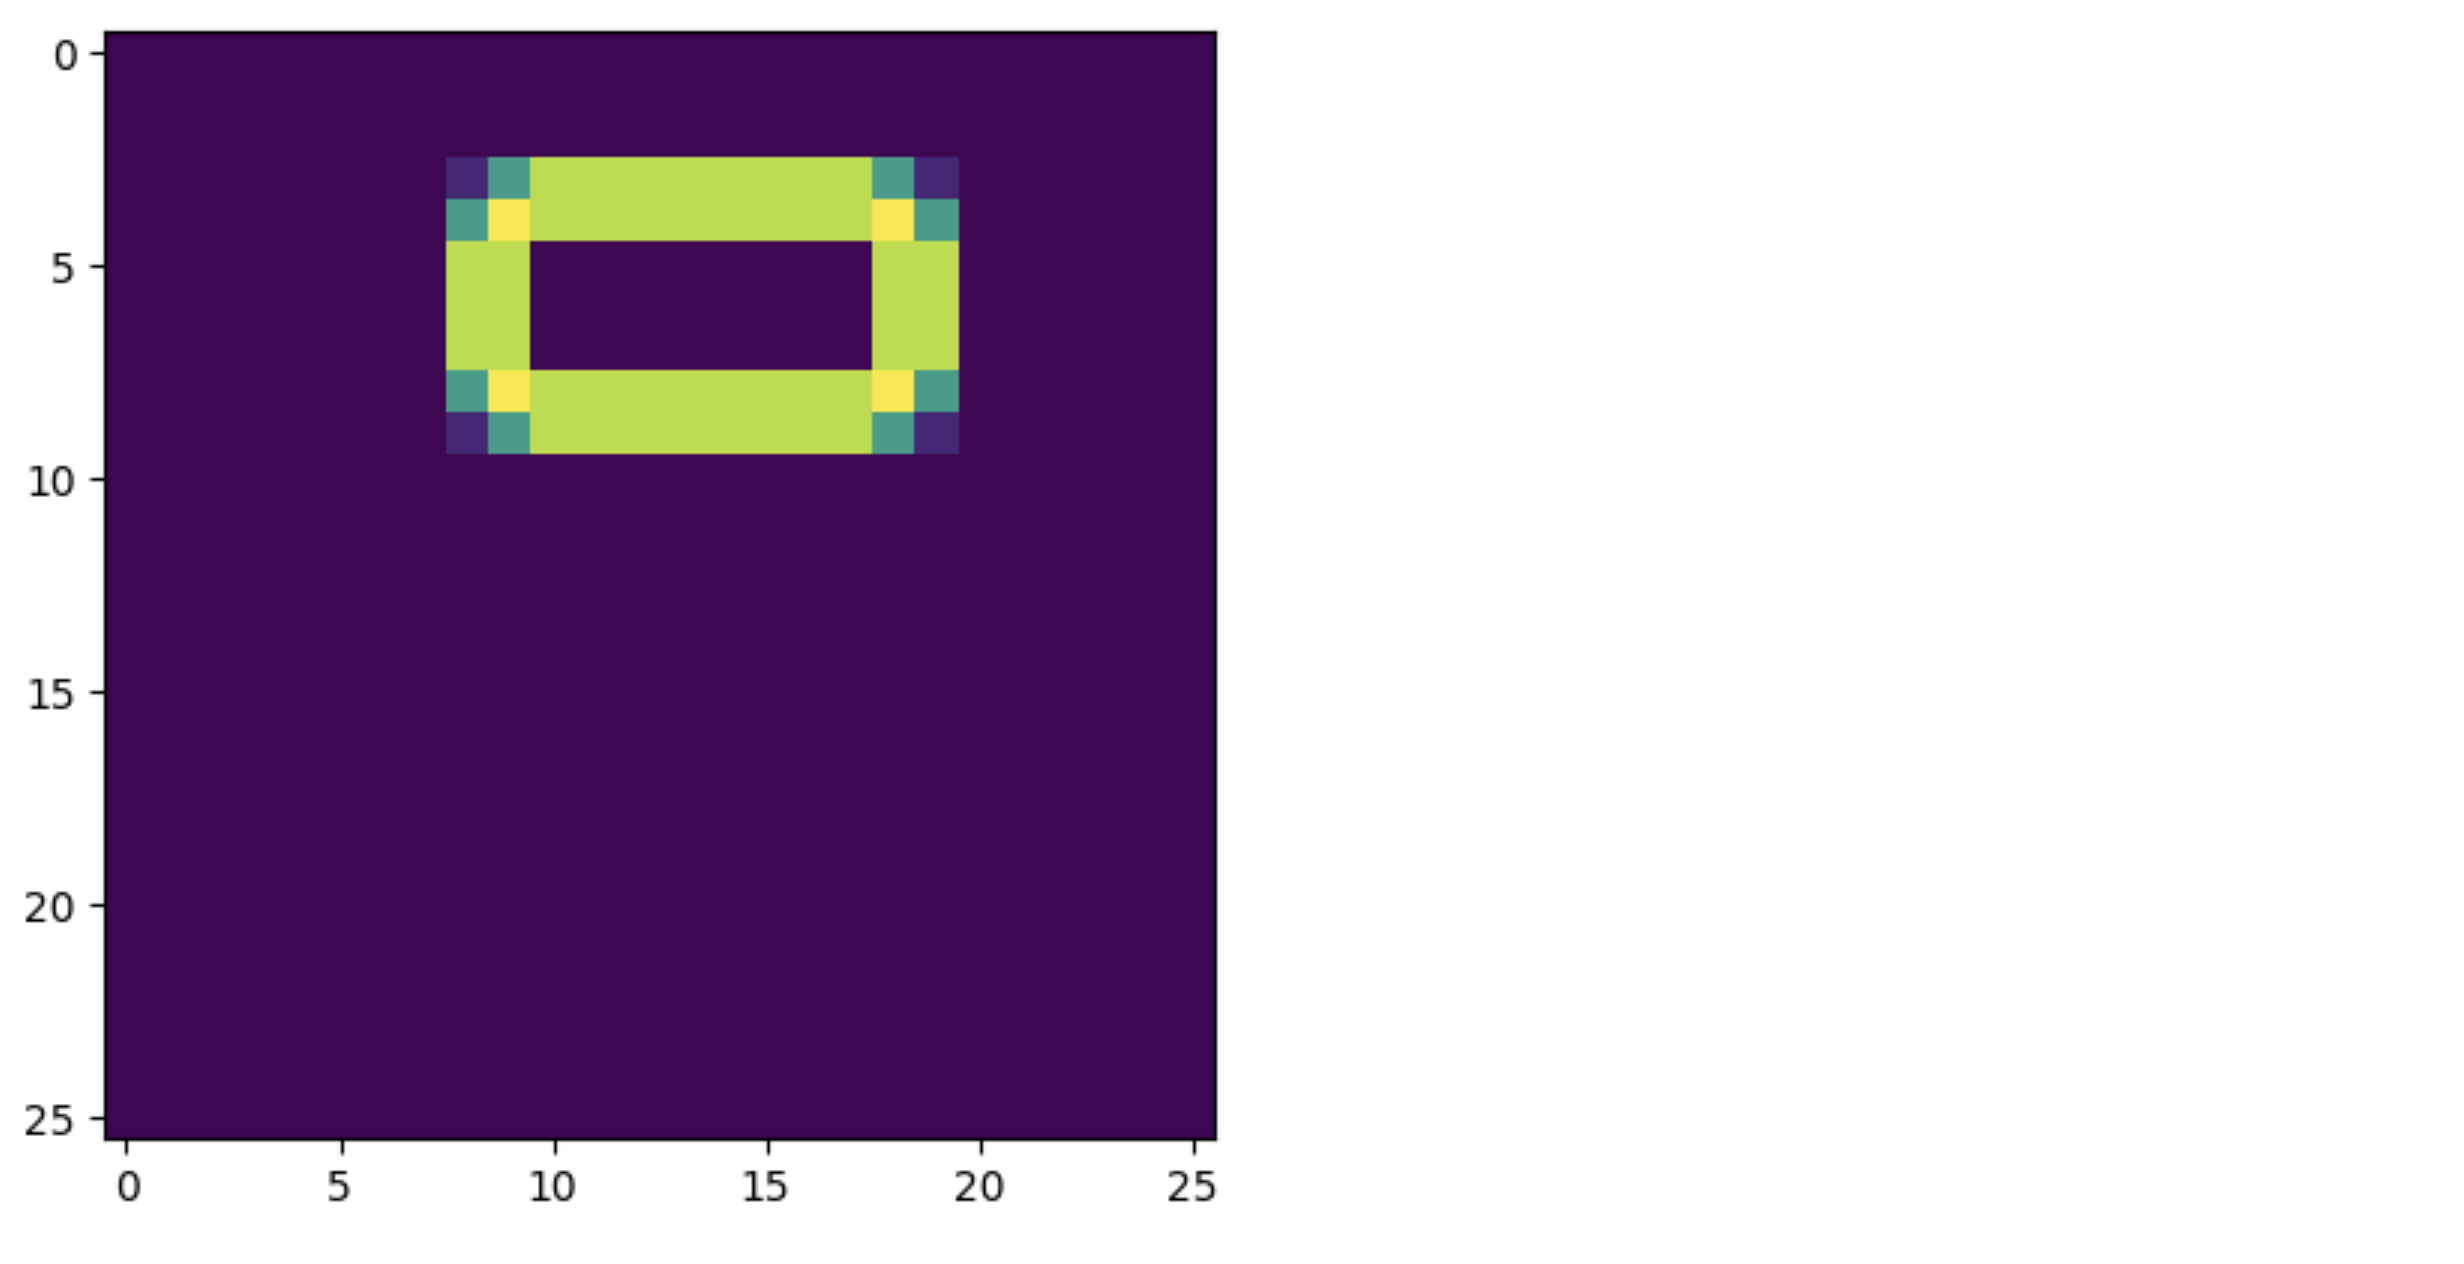

Mais on aimerait une image binaire

In [ ]:
border.min(),border.max()

In [ ]:
border = ...
plt.imshow(border);

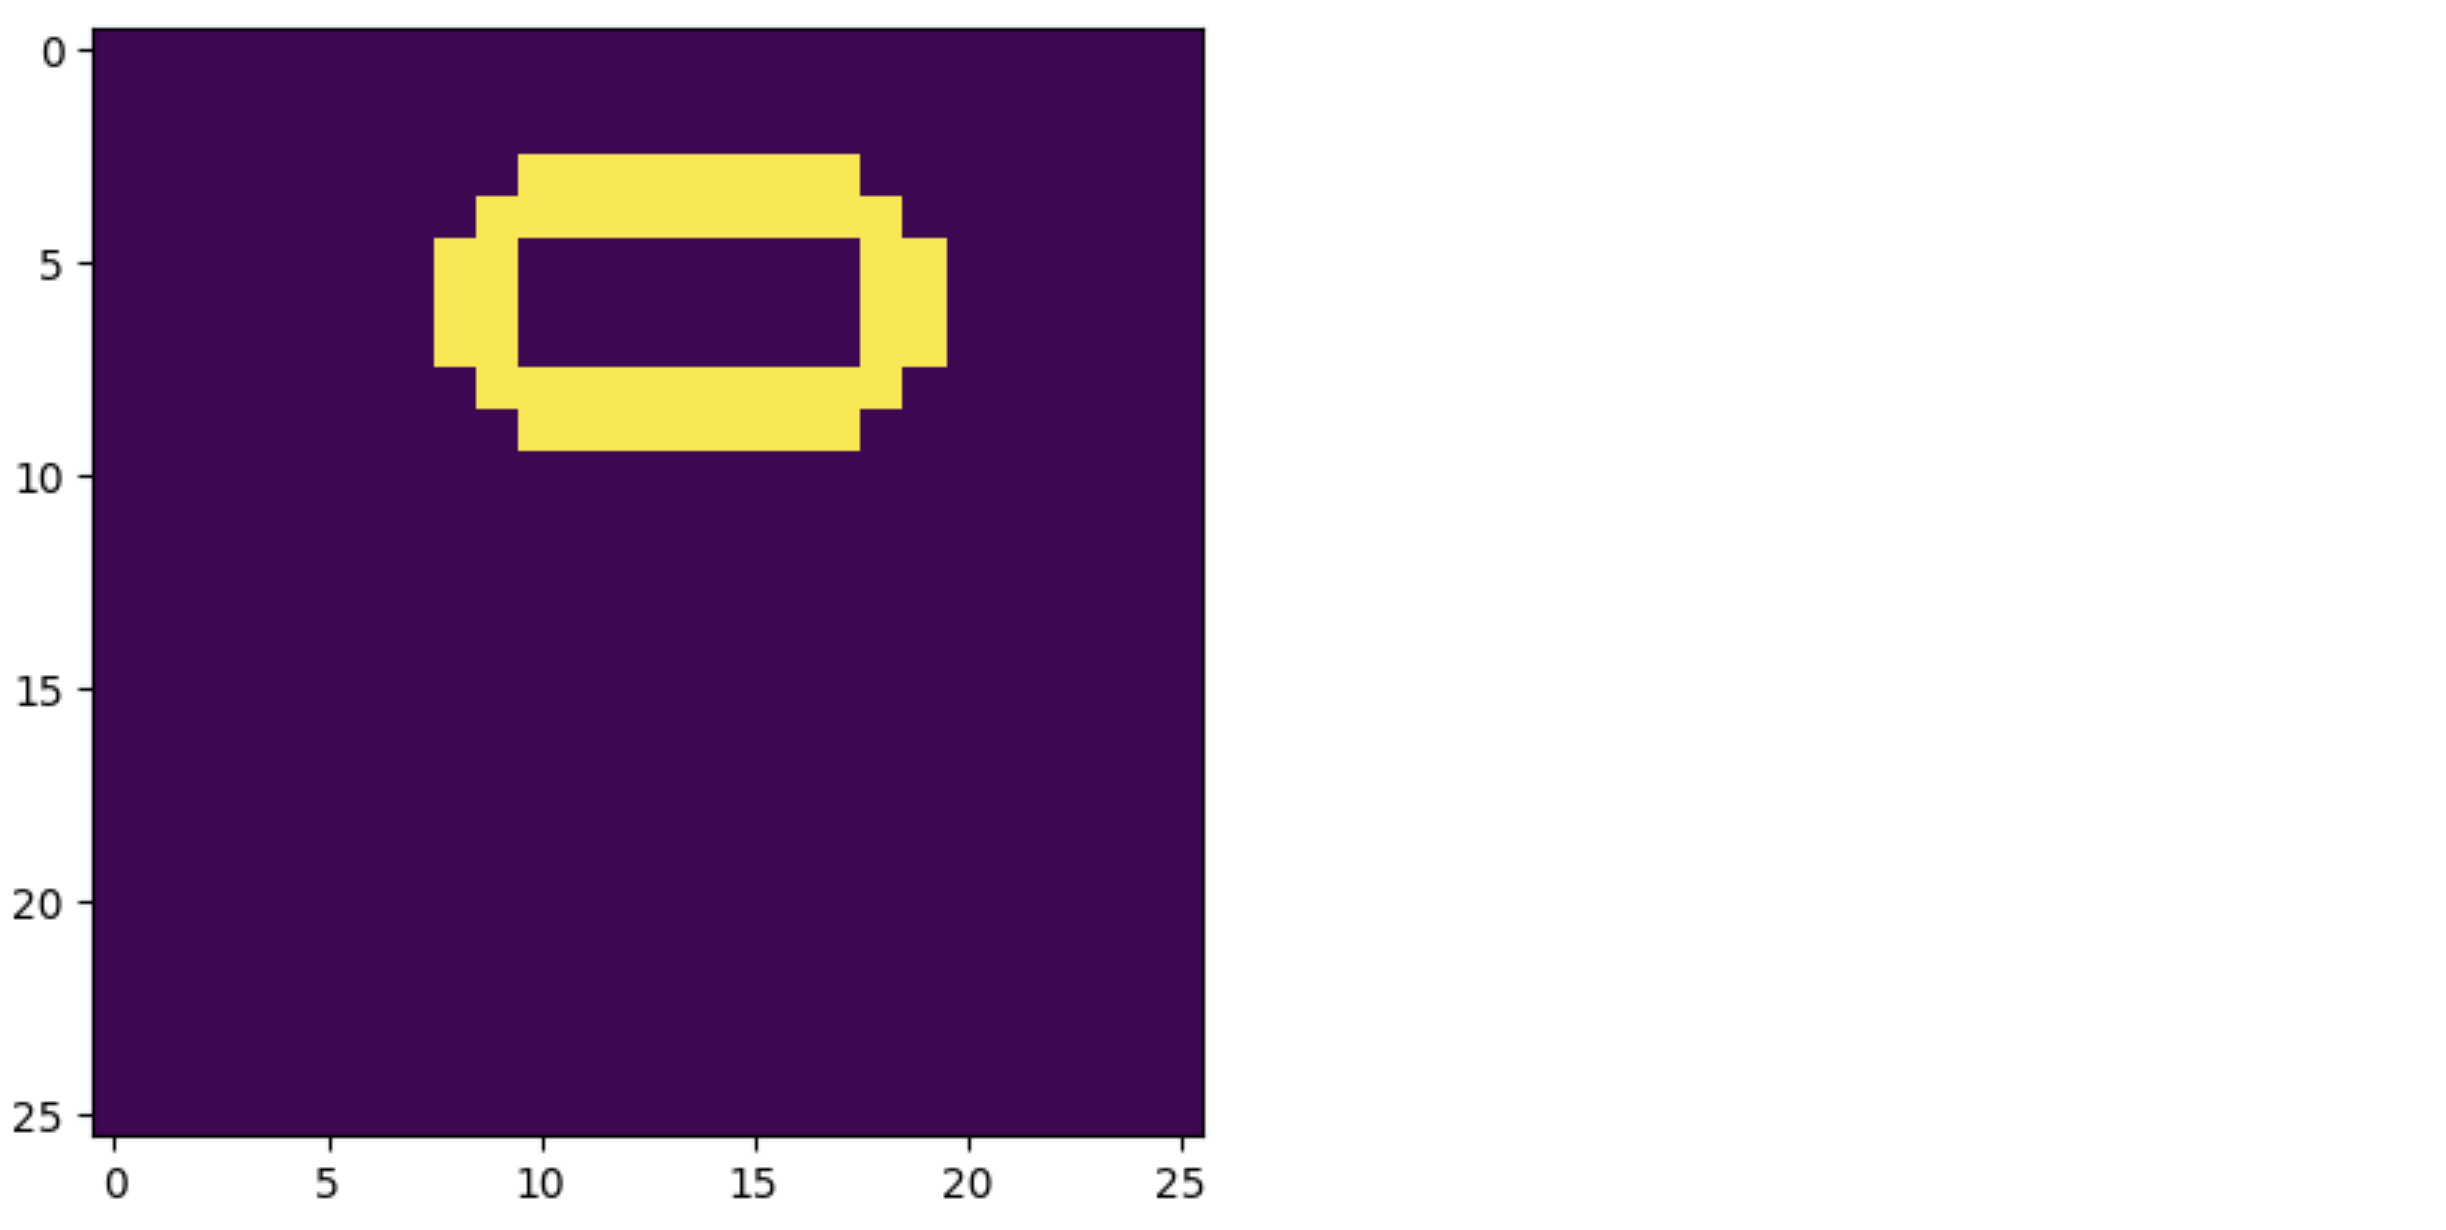